In [2]:
import cv2 #opencv读取的格式是BGR
import numpy as np
import matplotlib.pyplot as plt#Matplotlib是RGB
%matplotlib inline 

In [3]:
img=cv2.imread('img/cat.jpg')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

### 图像的梯度
梯度简单来说就是求导，在图像上表现出来的就是提取图像的边缘（无论是横向的、纵向的、斜方向的等等），所需要的无非就是一个核模板。模板的不同结果也不同

#### 图像梯度-Sobel算子

1.Sobel算子用来计算图像灰度函数的近似梯度。Sobel算子根据像素点上下、左右邻点灰度加权差，在边缘处达到极值这一现象检测边缘。对噪声具有平滑作用，提供较为精确的边缘方向信息，边缘定位精度不够高。当对精度要求不是很高时，是一种较为常用的边缘检测方法。

2.Sobel具有平滑和微分的功效。即：Sobel算子先将图像横向或纵向平滑，然后再纵向或横向差分，得到的结果是平滑后的差分结果。

dst = cv2.Sobel(src, ddepth, dx, dy, ksize)
- ddepth:图像的深度
- dx和dy分别表示水平和竖直方向
- ksize是Sobel算子的大小


![title](img/sobel_1.png)

In [33]:
img = cv2.imread('img/pie.png',cv2.IMREAD_GRAYSCALE)

In [34]:
def cv_show(img,name):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [35]:
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)

cv_show(sobelx,'sobelx')


白到黑是正数，黑到白就是负数了，所有的负数会被截断成0，所以要取绝对值

In [36]:
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
sobelx = cv2.convertScaleAbs(sobelx)
cv_show(sobelx,'sobelx')

In [37]:
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
sobely = cv2.convertScaleAbs(sobely)  
cv_show(sobely,'sobely')

In [38]:
#分别计算x和y，再求和
sobelxy = cv2.addWeighted(sobelx,0.5,sobely,0.5,0)
cv_show(sobelxy,'sobelxy')

In [39]:
sobelxy=cv2.Sobel(img,cv2.CV_64F,1,1,ksize=3)
sobelxy = cv2.convertScaleAbs(sobelxy) 
cv_show(sobelxy,'sobelxy')

In [45]:
img = cv2.imread('img/lena.jpg',cv2.IMREAD_GRAYSCALE)
cv_show(img,'img')

In [47]:
img = cv2.imread('img/lena.jpg',cv2.IMREAD_GRAYSCALE)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
sobelx = cv2.convertScaleAbs(sobelx)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
sobely = cv2.convertScaleAbs(sobely)
sobelxy = cv2.addWeighted(sobelx,0.5,sobely,0.5,0)
cv_show(sobelxy,'sobelxy')

#### 图像梯度-Scharr算子
scharr算子相当于sobel的加强版，不过这样其抗噪能力就会减弱

![title](img/scharr.png)

### 图像梯度-laplacian算子

![title](img/l.png)

In [48]:
#不同算子的差异
img = cv2.imread('img/lena.jpg',cv2.IMREAD_GRAYSCALE)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
sobelx = cv2.convertScaleAbs(sobelx)   
sobely = cv2.convertScaleAbs(sobely)  
sobelxy =  cv2.addWeighted(sobelx,0.5,sobely,0.5,0)  

scharrx = cv2.Scharr(img,cv2.CV_64F,1,0)
scharry = cv2.Scharr(img,cv2.CV_64F,0,1)
scharrx = cv2.convertScaleAbs(scharrx)   
scharry = cv2.convertScaleAbs(scharry)  
scharrxy =  cv2.addWeighted(scharrx,0.5,scharry,0.5,0) 

laplacian = cv2.Laplacian(img,cv2.CV_64F)
laplacian = cv2.convertScaleAbs(laplacian)   

res = np.hstack((sobelxy,scharrxy,laplacian))
cv_show(res,'res')

### Canny边缘检测
- 1)        使用高斯滤波器，以平滑图像，滤除噪声。

- 2)        计算图像中每个像素点的梯度强度和方向。

- 3)        应用非极大值（Non-Maximum Suppression）抑制，以消除边缘检测带来的杂散响应。

- 4)        应用双阈值（Double-Threshold）检测来确定真实的和潜在的边缘。

- 5)        通过抑制孤立的弱边缘最终完成边缘检测。

Canny边缘检测是一种流行的边缘检测算法。它是由约翰·F·坎尼于1986年开发的。这是一个多阶段的算法。


#### 降噪

由于边缘检测对图像中的噪声很敏感，第一步是用5x5高斯滤波器去除图像中的噪声。 
![title](img/canny_1.png)


#### 图像强度梯度的求取
然后在水平方向和垂直方向用Sobel核对平滑后的图像进行滤波，得到水平方向的一阶导数和垂直方向从这两幅图像中，我们可以找到每个像素的边缘梯度和方向如下：
![title](img/qiangdu.png)


梯度方向总是垂直于边缘。它是圆形的四个角之一，代表垂直，水平和两个对角线方向。


#### 非极大抑制

在获得梯度幅值和方向后，对图像进行全面扫描，以消除可能不构成边缘的任何不需要的像素。为此，在每个像素上，检查像素是否是其邻域内沿梯度方向的局部最大值。检查下面的图像：
![title](img/nms.jpg)
A点在边缘(垂直方向)。梯度方向是正常的边缘。点B和C呈梯度方向。因此，用点B和点C检查点A，看看它是否形成局部最大值。如果是，则考虑到下一阶段，否则就会被抑制(将为零)。

简而言之，你得到的结果是一幅带有“薄边”的二值图像。

#### 迟滞阈值

这个阶段决定了哪些是边缘，哪些是真正的边，哪些不是边。为此，我们需要两个阈值，MinVal和MaxVal。任何强度梯度大于MaxVal肯定是边，而小于MinVal肯定是非边缘的，所以被丢弃了。处于这两个阈值之间的人根据其连通性分为边缘或非边缘。如果它们连接到“确定边缘”像素，则它们被视为边缘的一部分。否则，它们也会被丢弃。


    第一个参数是我们的输入图像。
    第二个和第三个参数分别是我们的MinVal和MaxVal。
    第四个参数是aperture_size。它是用于查找图像梯度的Sobel核的大小。默认情况下是3。
    最后一个参数是L2gradient ，它指定了求梯度幅值的公式。

In [50]:
img=cv2.imread("img/lena.jpg",cv2.IMREAD_GRAYSCALE)

v1=cv2.Canny(img,80,150)
v2=cv2.Canny(img,50,100)

res = np.hstack((v1,v2))
cv_show(res,'res')


### 图像金字塔


有些情况下，我们需要对同一图像的不同分辨率的子图像进行处理。比如，我们要在一幅图像中查找某个目标，比如脸，我们不知道目标在图像中的尺寸大小。这种情况下，我们需要创建一组图像，这些图像是具有不同分辨率的原始图像。我们把这组图像叫做图像金字塔（简单来说就是同一图像的不同分辨率的子图集合）。如果我们把最大的图像放在底部，最小的放在顶部，看起来像一座金字塔，故而得名图像金字塔。

- 高斯金字塔
- 拉普拉斯金字塔

高斯金字塔是由底部的最大分辨率图像逐次向下采样得到的一系列图像。最下面的图像分辨率最高，越往上图像分辨率越低。高斯金字塔的向下采样过程是：对于给定的图像先做一次高斯平滑处理，也就是使用一个大小为的卷积核对图像进行卷积操作，然后再对图像采样，去除图像中的偶数行和偶数列，然后就得到一张图片，对这张图片再进行上述操作就可以得到高斯金字塔。
在opencv的官方网站上给出了这个的卷积核，如下所示：

高斯金字塔：向下采样方法（缩小）假设原先的图片的长和宽为M、N，经过一次采样后，图像的长和宽会分别变成[M+1]/2，[N+1]/2，由此可见，图像的面积变为了原来的1/4，图像的分辨率变成了原来的1/4。
![title](img/Pyramid_2.png)

高斯金字塔：向上采样方法（放大）
![title](img/Pyramid_3.png)

拉普拉金字塔的图像看起来就像边界图，其中很多像素都是0。他们经常被用在图像压缩中。

图像金字塔的一个典型应用是图像融合。例如，在图像缝合中，你需要将两幅图叠在一起，但是由于连接区域图像像素的不连续性，整幅图的效果看起来会很差。这时图像金字塔就可以排上用场了，他可以帮你实现无缝连接。


- 加载苹果和梨的两个图像
- 查找用于苹果和橙色的高斯金字塔(在本例中，级别数为6)
- 从高斯金字塔中找到它们的拉普拉斯金字塔
- 现在，在拉普拉斯金字塔的每一层加入苹果的左半和橙色的右半。
- 最后，从这个联合图像金字塔，重建原始图像。

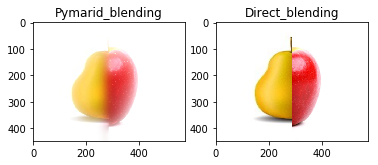

In [57]:
import cv2 as cv
import numpy as np,sys
import matplotlib.pyplot as plt
A = cv.imread('img/li1.jpg')
B = cv.imread('img/33.jpg')
#将两张图片的大小调整至一致，这里分别取出图片的长和宽，然后再除以64取整再乘以64的原因是：
#我们在后面会构建一个6层的高斯金字塔，并由之计算出拉普拉斯金字塔，由于在向下采样的过程中，
#长度和宽度会逐次减半，当长度和宽度不能被2整除时就容易出现错误，所以我们在开始时就将图片
#的长度和宽度调整至64的倍数
x,y=B.shape[0:2]
x=(x//64)*64
y=(y//64)*64
A=cv.resize(A,(y,x))
B=cv.resize(B,(y,x))
#产生A的高斯金字塔
G = A.copy()
gpA = [G]
for i in range(6):
    #向下采样
    G = cv.pyrDown(G)
    gpA.append(G)
##产生B的高斯金字塔
G = B.copy()
gpB = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpB.append(G)
#产生A的拉普拉斯金字塔
lpA = [gpA[5]]
for i in range(5,0,-1):
    GE = cv.pyrUp(gpA[i])
    L = cv.subtract(gpA[i-1],GE)
    lpA.append(L)
#产生B的拉普拉斯金字塔
lpB = [gpB[5]]
for i in range(5,0,-1):
    GE = cv.pyrUp(gpB[i])
    L = cv.subtract(gpB[i-1],GE)
    lpB.append(L)
#将第一张图片的左半边和第二张图片的右半边相加
LS = []
for la,lb in zip(lpA,lpB):
    rows,cols,dpt = la.shape
    #numpy数组水平组合
    ls = np.hstack((la[:,0:cols//2], lb[:,cols//2:]))
    LS.append(ls)
# 图像重建
#LS[0]是具有最低分辨率的彩色图像，即高斯金字塔的最高层图像
ls_ = LS[0]
for i in range(1,6):
    #由最低分辨率图像向上采样
    ls_ = cv.pyrUp(ls_)
    #将采样后的图片与同层的拉普拉斯金字塔图像相加
    ls_ = cv.add(ls_, LS[i])

#将两幅图片直接相加
real = np.hstack((A[:,:cols//2],B[:,cols//2:]))

#将图片的模式转变为RGB模式，因为在opencv中加载图片的方式为BGR,
#而在matplotlib中显示的模式是RGB
ls_=cv.cvtColor(ls_,cv.COLOR_BGR2RGB)
real=cv.cvtColor(real,cv.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(ls_),plt.title("Pymarid_blending")
plt.subplot(122),plt.imshow(real),plt.title("Direct_blending")
plt.show()

### 图像轮廓

#### cv2.findContours(img,mode,method)
mode:轮廓检索模式
- RETR_EXTERNAL ：只检索最外面的轮廓；
- RETR_LIST：检索所有的轮廓，并将其保存到一条链表当中；
- RETR_CCOMP：检索所有的轮廓，并将他们组织为两层：顶层是各部分的外部边界，第二层是空洞的边界;
- RETR_TREE：检索所有的轮廓，并重构嵌套轮廓的整个层次;

method:轮廓逼近方法
- CHAIN_APPROX_NONE：以Freeman链码的方式输出轮廓，所有其他方法输出多边形（顶点的序列）。
- CHAIN_APPROX_SIMPLE:压缩水平的、垂直的和斜的部分，也就是，函数只保留他们的终点部分。

In [58]:
#需要注意的是cv2.findContours()函数接受的参数为二值图，即黑白的（不是灰度图）
img = cv2.imread('img/contours.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
cv_show(thresh,'thresh')

In [60]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

cv2.drawContours(image, contours, contourIdx, color[, thickness[, lineType[, hierarchy[, maxLevel[, offset ]]]]]) 

    第一个参数是指明在哪幅图像上绘制轮廓；
    第二个参数是轮廓本身，在Python中是一个list。
    第三个参数指定绘制轮廓list中的哪条轮廓，如果是-1，则绘制其中的所有轮廓。后面的参数很简单。其中thickness表明轮廓线的宽度，如果是-1（cv2.FILLED），则为填充模式。

In [61]:
#传入绘制图像，轮廓，轮廓索引，颜色模式，线条厚度
# 注意需要copy,要不原图会变。。。
draw_img = img.copy()
res = cv2.drawContours(draw_img, contours, -1, (0, 0, 255), 2)
cv_show(res,'res')

#### 轮廓特征

In [62]:
cnt = contours[0]

In [63]:
#面积
cv2.contourArea(cnt)

8500.5

In [64]:
#周长，True表示闭合的
cv2.arcLength(cnt,True)

437.9482651948929

轮廓近似

In [65]:
epsilon = 0.15*cv2.arcLength(cnt,True) 
approx = cv2.approxPolyDP(cnt,epsilon,True)

draw_img = img.copy()
res = cv2.drawContours(draw_img, [approx], -1, (0, 0, 255), 2)
cv_show(res,'res')

In [66]:
#边界矩形
x,y,w,h = cv2.boundingRect(cnt)
img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
cv_show(img,'img')

In [68]:
#外接圆
(x,y),radius = cv2.minEnclosingCircle(cnt) 
center = (int(x),int(y)) 
radius = int(radius) 
img = cv2.circle(img,center,radius,(0,255,0),2)
cv_show(img,'img')

### 模板匹配
模板匹配和卷积原理很像，模板在原图像上从原点开始滑动，计算模板与（图像被模板覆盖的地方）的差别程度，这个差别程度的计算方法在opencv里有6种，然后将每次计算的结果放入一个矩阵里，作为结果输出。假如原图形是AxB大小，而模板是axb大小，则输出结果的矩阵是(A-a+1)x(B-b+1)

In [4]:
# 模板匹配
img = cv2.imread('img/lena.jpg', 0)
template = cv2.imread('img/face.jpg', 0)
h, w = template.shape[:2] 

- TM_SQDIFF：计算平方不同，计算出来的值越小，越相关        
- TM_CCORR：计算相关性，计算出来的值越大，越相关
- TM_CCOEFF：计算相关系数，计算出来的值越大，越相关
- TM_SQDIFF_NORMED：计算归一化平方不同，计算出来的值越接近0，越相关
- TM_CCORR_NORMED：计算归一化相关性，计算出来的值越接近1，越相关
- TM_CCOEFF_NORMED：计算归一化相关系数，计算出来的值越接近1，越相关

In [5]:
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
           'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

4


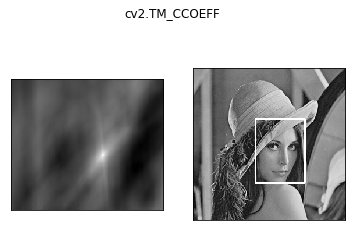

5


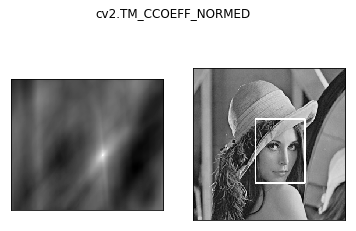

2


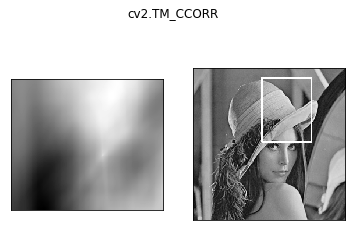

3


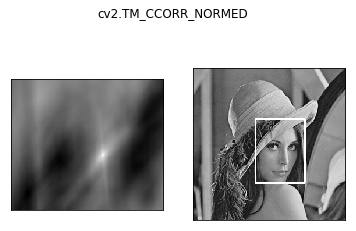

0


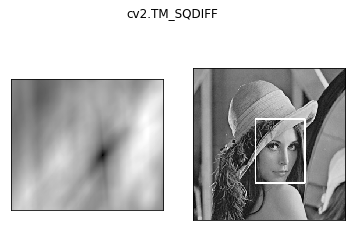

1


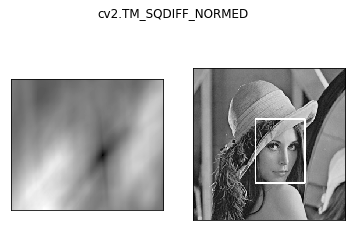

In [6]:
for meth in methods:
    img2 = img.copy()

    # 匹配方法的真值
    method = eval(meth)
    print (method)
    res = cv2.matchTemplate(img, template, method)
    #  cvMinMaxLoc()找出图片或一组数据中最大值及最小值的数据,以及最大值及最小值的位置
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # 如果是平方差匹配TM_SQDIFF或归一化平方差匹配TM_SQDIFF_NORMED，取最小值
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    # 画矩形
    cv2.rectangle(img2, top_left, bottom_right, 255, 2)

    plt.subplot(121), plt.imshow(res, cmap='gray')
    plt.xticks([]), plt.yticks([])  # 隐藏坐标轴
    plt.subplot(122), plt.imshow(img2, cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()